In [70]:
import pandas as pd
import json
import numpy as np
from ast import literal_eval
from glob import glob
from collections import defaultdict

In [85]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [86]:
import seaborn as sns

In [2]:
df_event = pd.read_csv("../data/events/events_actors_wiki2data.csv")

In [59]:
wiki2data_ids = df_event["wikidata_ids"].tolist()
wiki2data_ids_ = [literal_eval(x) for x in wiki2data_ids]
wiki2data_ids_= [ [int(x) for x in y] for y in wiki2data_ids_]
df_event["wikidata_ids"] = wiki2data_ids_
df_event["event_id"]= df_event.index

In [15]:
event2wikidata= dict(zip(df_event["event_id"], df_event["wikidata_ids"]))

In [16]:
for event_id, wiki2dataids in event2wikidata.items():
    if len(wiki2dataids) <= 0:
        print(event_id)

In [14]:
df_event[df_event["event_id"]==21]

,category,event_text,main_event,date,news,entities,first_sentence,first_actor,wikidata_ids,wikidata_labels,wiki2data_ids,wiki2data_labels,event_id
21,Armed conflicts and attacks,Ukraine suspends diplomatic relations with Rus...,Russo-Ukrainian War,2022-02-24,['https://www.timesofisrael.com/liveblog_entry...,[],Ukraine suspends diplomatic relations with Rus...,Ukraine,"[212, 277521, 159, 7315950, 467011]","['Ukraine', 'relation', 'Russia', 'response', ...",[],[],21


In [4]:
for file in glob("../data/wikidata/tweets_wikidata_*.csv"):
    df = pd.read_csv(file)

In [106]:
df_tweet = pd.read_csv("../data/wikidata/tweets_wikidata_2022-02-24 00:00:00.csv")

In [107]:
wikidata_ids = df_tweet["wikidata_ids"].tolist()
wikidata_ids_ = [literal_eval(x) for x in wikidata_ids]
wikidata_ids_= [ [int(x) for x in y] for y in wikidata_ids_]
df_tweet["wikidata_ids"] = wikidata_ids_

In [109]:
def matching_tweets_event(df_event, df_tweets):
    tweet_date = df_tweets["date"].tolist()[0]
    df_event = df_event[df_event["date"]<=tweet_date] # tweet should be after event date.
    print(df_event.date.value_counts())
    event2wikidata= dict(zip(df_event["event_id"], df_event["wikidata_ids"]))
    tweet2wikidata= dict(zip(df_tweets["id"], df_tweets["wikidata_ids"]))
    
    tweet2event_dict= defaultdict(dict)
    
    for tweet_id, tweet_ents in tweet2wikidata.items():
        
        for event_id, event_ents in event2wikidata.items():
            event_labels_len = len(event_ents)
            inters = list(set(event_ents).intersection(set(tweet_ents)))
            if len(inters)>0:
                if event_labels_len>0:
                    score = len(inters)/event_labels_len
                    if score >0:
                        if tweet_id not in tweet2event_dict:
                            tweet2event_dict[tweet_id] = dict()
                            tweet2event_dict[tweet_id][event_id]=score
                        else:
                            tweet2event_dict[tweet_id][event_id]=score
                        
    return tweet2event_dict

In [110]:
hashtag ="278485"

In [111]:
%time tweet2event_dict = matching_tweets_event(df_event, df_tweet)

2022-02-24    43
Name: date, dtype: int64
CPU times: user 3.11 s, sys: 33.2 ms, total: 3.15 s
Wall time: 3.15 s


In [112]:
def get_tweet_event_score(tweet2event_dict):
    tweet2event_score = defaultdict(dict)

    for tweet_id, event_score in tweet2event_dict.items():
        event_score = sorted(event_score.items(), key=lambda item: item[1], reverse=True)
        event_id, score = event_score[0]

        tweet2event_score[tweet_id]={"event_id":event_id, "score":score}
    
    # convert dictionary to dataframe
    tweet2event_df = pd.DataFrame.from_dict(tweet2event_score, orient="index")
    tweet2event_df["id"]=tweet2event_df.index
    return tweet2event_df

In [113]:
tweet2event_df = get_tweet_event_score(tweet2event_dict)

In [114]:
len(df_tweet), len(tweet2event_df)

(110338, 104886)

In [115]:
df_merged = pd.merge(df_tweet, tweet2event_df, on="id")

In [116]:
df_= df_merged[df_merged['score']>0.5]

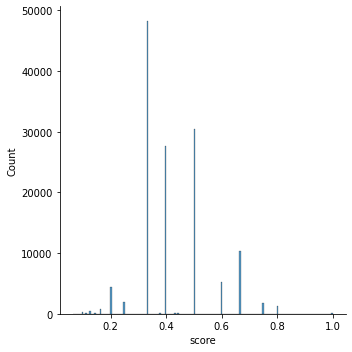

In [89]:
sns.displot(tweet2event_df, x="score")

In [78]:
tweet2event_df

,event_id,score
1497092135623012355,59,0.500000
1497092072523792384,49,0.400000
1497091984858791942,6,0.666667
1497091946271100929,6,0.333333
1497091863932813329,58,0.200000
...,...,...
1497237538242805762,65,0.400000
1497237525773045770,67,0.400000
1497237519443927052,20,0.400000
1497237510174429189,78,0.333333
